In [6]:
# Potential issues:
# No Segmentation → Model May Learn Irrelevant Features
# Learning Rate Might Not Be Optimal (higher if not learning, lower if overfitting)
# Image Resolution Might Be Too Low (128x128)
# Batch Size (32) Might Be Suboptimal (try 16 or 64)
# If you didn’t use flipping, rotation, brightness changes, or color jittering, your model might overfit to training images and fail on new ones.
#

import torch
from torch import nn

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

batchSize = 32
imageResolution = 224
pixel_min = 5000
threshold = 0.2

import torch
print(torch.__version__)


cuda
2.7.0+cu118


In [7]:
#set up UNet model
from model import UNet

# instantiate & load weights
seg_model = UNet(n_channels=3, n_classes=1, bilinear=False)
seg_model.load_state_dict(torch.load(
    'C:/Users/Fourth/models/unet_dice0.8369_save1746204838.pt',
    map_location=device
))
seg_model.to(device).eval()


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [8]:
from PIL import ImageDraw

def circular_crop(img, radius_ratio=0.4):
    w, h = img.size
    r = int(min(w, h) * radius_ratio)
    cx, cy = w // 2, h // 2

    mask = Image.new('L', (w, h), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((cx - r, cy - r, cx + r, cy + r), fill=255)

    result = Image.new("RGB", (w, h))
    result.paste(img, mask=mask)
    return result


In [9]:
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision.transforms.functional as TF

import torch

class SegmentationPreprocessedDataset(Dataset):
    def __init__(self, base_dataset, segmentation_model, device='cpu', threshold=threshold, transform=None):
        self.base_dataset = base_dataset
        self.segmentation_model = segmentation_model.to(device).eval()
        self.device = device
        self.threshold = threshold
        self.transform = transform  # 👈 Add this

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        original_image = TF.to_pil_image(image)

        # Preprocess for UNet (e.g. resize to 300x300)
        preprocess = T.Compose([
            T.Resize((300, 300)),
            T.ToTensor()
        ])
        input_tensor = preprocess(original_image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.segmentation_model(input_tensor)
            mask = (output > self.threshold).float().squeeze(0)

        # Resize mask to match original image resolution
        mask = T.Resize(original_image.size[::-1])(mask)  # PIL size is (W, H), PyTorch is (H, W)

        mask = mask.to(self.device)
        
        # ⛑️ Safety mechanism: fallback if mask is too sparse
        #try 1000 next?
        min_pixel_threshold = pixel_min  # or use a ratio like 0.005 * mask.numel()
        if mask.sum().item() < min_pixel_threshold:
            # Fallback: either return original image or a circular crop
            masked_pil = circular_crop(original_image)  # define circular_crop elsewhere
        else:
            # Apply mask
            #masked_image = TF.to_tensor(original_image) * mask
            masked_image = TF.to_tensor(original_image).to(self.device) * mask  # Move original image to the same device as mask
            masked_pil = TF.to_pil_image(masked_image)

        if self.transform:
            masked_pil = self.transform(masked_pil)  # 👈 Apply your original data_transform here

        return masked_pil, label

    def __len__(self):
        return len(self.base_dataset)



In [10]:
import requests
import zipfile
from pathlib import Path
import shutil

# Setup path to data folder (WindowsPath objects)
data_path = Path("C:/Users/Fourth/data/")
image_path = data_path / "melanoma_cancer_dataset/"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download dataset
    with open(data_path / "Melanoma-dataset.zip", "wb") as f:
        request = requests.get("https://github.com/thereal4th/Melanoma-dataset/archive/refs/heads/main.zip")
        print("Downloading melanoma dataset...")
        f.write(request.content)

    # Unzip zip file
    with zipfile.ZipFile(data_path / "Melanoma-dataset.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

    # when Melanoma-dataset.zip is unzipped, it becomes a Melanoma-dataset-main directory
    # Move train and test directories outside of zip folder to melanoma_cancer_dataset
    train_dir = data_path/ "melanoma_cancer_dataset/Melanoma-dataset-main/train" # original train directory
    test_dir = data_path/ "melanoma_cancer_dataset/Melanoma-dataset-main/test" # original test directory

    # Move the entire directory
    print("Moving train and test datasets...")
    shutil.move(str(train_dir), str(image_path / train_dir.name))
    shutil.move(str(test_dir), str(image_path / test_dir.name))

C:\Users\Fourth\data\melanoma_cancer_dataset directory exists.


In [11]:
# Setup new train and testing paths
# these are WindowsPath objects
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(WindowsPath('C:/Users/Fourth/data/melanoma_cancer_dataset/train'),
 WindowsPath('C:/Users/Fourth/data/melanoma_cancer_dataset/test'))

In [12]:
#walk through the directory to view the image paths

import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

#call the function
walk_through_dir(image_path)

There are 3 directories and 0 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset'.
There are 0 directories and 1 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\Melanoma-dataset-main'.
There are 2 directories and 0 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\test'.
There are 0 directories and 497 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\test\benign'.
There are 0 directories and 487 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\test\malignant'.
There are 2 directories and 0 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\train'.
There are 0 directories and 4974 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\train\benign'.
There are 0 directories and 4592 images in 'C:\Users\Fourth\data\melanoma_cancer_dataset\train\malignant'.


In [13]:
print(f"Image path: {image_path}")
print(f"Exists: {image_path.exists()}")
print(f"Contents: {list(image_path.iterdir())}")
print("test")


Image path: C:\Users\Fourth\data\melanoma_cancer_dataset
Exists: True
Contents: [WindowsPath('C:/Users/Fourth/data/melanoma_cancer_dataset/Melanoma-dataset-main'), WindowsPath('C:/Users/Fourth/data/melanoma_cancer_dataset/test'), WindowsPath('C:/Users/Fourth/data/melanoma_cancer_dataset/train')]
test


Random image path: C:\Users\Fourth\data\melanoma_cancer_dataset\train\benign\melanoma_920.jpg
Image class: benign
Image height: 300
Image width: 300


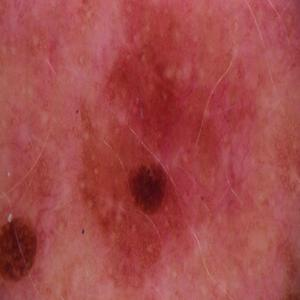

In [14]:
import random
from PIL import Image

# Set seed
random.seed() # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg")) # array containing image paths

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path) # displays the image

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

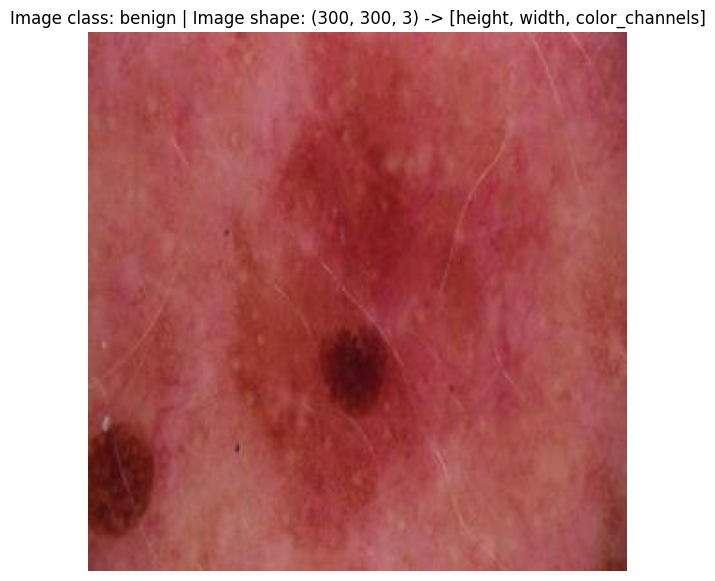

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into a numpy array
img_as_array = np.asarray(img)
#print(img_as_array)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [17]:
# Simple transform pipeline using transforms.Compose
to_tensor_transform = transforms.Compose([transforms.ToTensor()])


# Write transform for image
data_transform = transforms.Compose([
    # crop the images to minimize black borders
    # for some reason, cropping on some images increases the probability closer to 1 (malignant)
    # transforms.CenterCrop((250, 250)),
    # transform images to the value of imageResolution
    transforms.Resize(size=(imageResolution, imageResolution)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

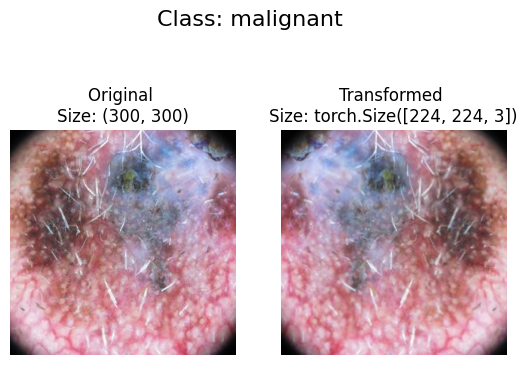

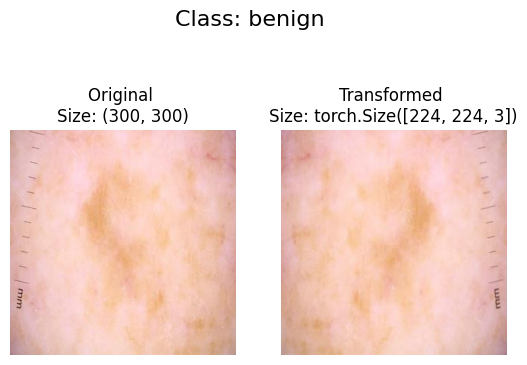

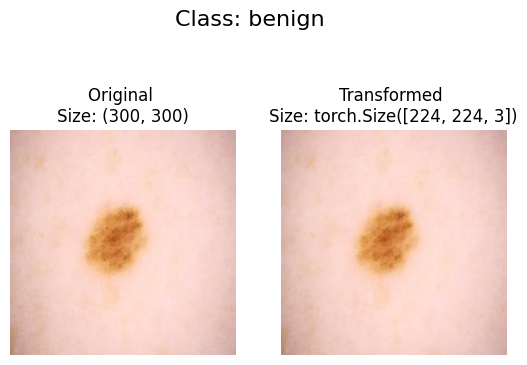

In [18]:
# not used for training, only for visualization
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    #random.seed(seed)
    random.seed()
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f: #the image.open() method takes in an image path and opens the image.
            fig, ax = plt.subplots(1, 2) # 1 row and 2 columns
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16) # .parent attribute refers to parent directories and .stem takes the name of the directories (benign or malignant)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [19]:
# Use ImageFolder class from datasets module from torchvision package to create dataset(s)
# ImageFolder assumes a proper structure of directories for your dataset in order to read the classes (labels) correctly.
from torchvision import datasets #import datasets module from the torchvision package
#                               (a module is just a python file that contains classes and such, datasets.py is a module)
#                                a package is just a directory that organizes modules.
# construct ImageFolder object 
'''train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)'''

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=to_tensor_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=to_tensor_transform)

# Wrap datasets and pass in transform
segmented_train_data = SegmentationPreprocessedDataset(train_data, seg_model, device=device, transform=data_transform)
segmented_test_data = SegmentationPreprocessedDataset(test_data, seg_model, device=device, transform=data_transform)

# Wrap datasets and pass in transform
segmented_train_data = SegmentationPreprocessedDataset(train_data, seg_model, device=device, transform=data_transform)
segmented_test_data = SegmentationPreprocessedDataset(test_data, seg_model, device=device, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 9566
    Root location: C:\Users\Fourth\data\melanoma_cancer_dataset\train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 984
    Root location: C:\Users\Fourth\data\melanoma_cancer_dataset\test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [20]:
# Get class names as a list
# .classes comes with ImageFolder class
class_names = train_data.classes
class_names

['benign', 'malignant']

In [21]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'benign': 0, 'malignant': 1}

In [22]:
# Check the lengths
len(train_data), len(test_data)

(9566, 984)

In [23]:
#for visualization, check the first image and its label in the train dataset

img, label = segmented_train_data[0][0], segmented_train_data[0][1]

#the image tensors are in the first column and the labels are in the 2nd column
#the labels are labeled as numbers, 0 for benign and 1 for malignant. (i think this depends on the order of your folders in your folder structure)

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


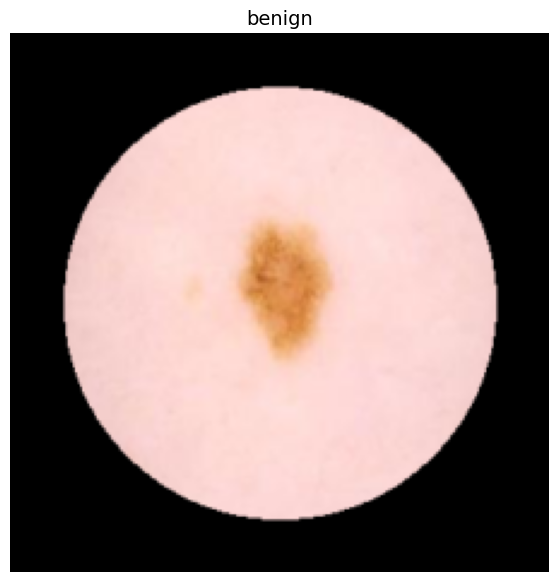

In [24]:
# Rearrange the order of dimensions
# not really used anywhere in the program, just demonstrated.
img_permute = img.permute(1, 2, 0) #originally (0, 1, 2) or (3, 224, 224)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [25]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=segmented_train_data, # train_data is the dataset object created from the ImageFolder class using the train_dir directory from PathLib
                              batch_size=batchSize, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=segmented_test_data, # test_data is the dataset object created from the ImageFolder class using the test_dir directory from PathLib
                             batch_size=batchSize,
                             num_workers=0,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x24c3636d410>,
 <torch.utils.data.dataloader.DataLoader at 0x24c39923e50>)

In [26]:
img, label = next(iter(train_dataloader))
# img contains image tensors
# label contains the classess, 0 or 1 for benign or malignant.

# Batch size will now be 16, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Make function to find classes in target directory
# helper function
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
#print classes

find_classes(train_dir)

(['benign', 'malignant'], {'benign': 0, 'malignant': 1})

EXPERIMENTAL

In [30]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

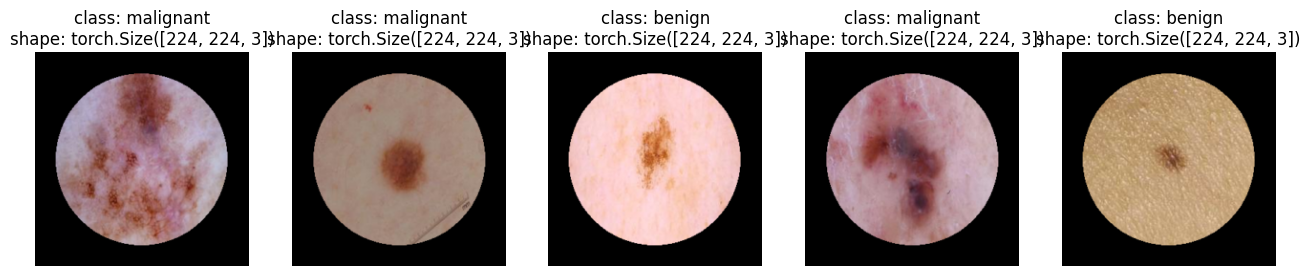

In [39]:
# Display random images from ImageFolder created Dataset
display_random_images(segmented_train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [27]:
  class MelanomaClassifier(nn.Module):
    """
    Model architecture TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                          stride=2) # default stride value is same as kernel_size

        )

        hidden_units_B = hidden_units * 2 #increase out-feautures hidden units (32 to 64)
        print(hidden_units_B) # debug

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units_B, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        hidden_units = hidden_units_B * 2 #increase out-feautures hidden units_B (64 to 128)
        print(hidden_units) # debug

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units_B, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        hidden_units_B = hidden_units * 2 #ncrease out-feautures hidden units (128 to 256)
        print(hidden_units_B) # debug
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units_B, hidden_units_B, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self._to_linear = None
        self._compute_linear_input_size(input_shape) #dynamically compute in_features

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=self._to_linear,
                      out_features=output_shape)

        )

    # Function to automate the calculation of in_features for the final nn.linear layer by passing a dummy tensor into the model.
    def _compute_linear_input_size(self, input_shape):
        """Pass a dummy tensor through conv layers by making an inference to determine in_features size."""
        with torch.no_grad():
            dummy_input = torch.randn(1, input_shape, imageResolution, imageResolution)  # Dummy tensor input to simulate the changes of the in_features as a tensor passes the conv blocks.
            output = self.conv_block_1(dummy_input)
            output = self.conv_block_2(output)
            output = self.conv_block_3(output)
            output = self.conv_block_4(output)
            self._to_linear = output.view(1, -1).shape[1]  # Flatten and get feature size
            print("Computed in_features:", self._to_linear)  # Debugging

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        print(f"Feature map shape before flattening: {x.shape}")  # Debugging line
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

  #create model instance
  torch.manual_seed(42)
  model_0 = MelanomaClassifier(input_shape=3, # number of color channels (3 for RGB)
                    hidden_units=32, #initial hidden units
                    output_shape=1).to(device)
  model_0

64
128
256
Computed in_features: 50176


MelanomaClassifier(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), st

In [28]:
  # 1. Get a batch of images and labels from the DataLoader
  img_batch, label_batch = next(iter(train_dataloader))

  # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
  img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
  print(f"Single image shape: {img_single.shape}\n")

  # 3. Perform a forward pass on a single image
  model_0.eval()
  with torch.inference_mode():
      pred = model_0(img_single.to(device))

  # 4. Print out what's happening and convert model logits -> pred probs -> pred label
  print(f"Output logits:\n{pred}\n")
  print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
  print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
  print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Feature map shape before flattening: torch.Size([1, 256, 14, 14])
Output logits:
tensor([[-0.0091]], device='cuda:0')

Output prediction probabilities:
tensor([[1.]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


In [29]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, imageResolution, imageResolution]) # do a test pass through of an example input size

Feature map shape before flattening: torch.Size([1, 256, 14, 14])


Layer (type:depth-idx)                   Output Shape              Param #
MelanomaClassifier                       [1, 1]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 32, 224, 224]         9,248
│    └─ReLU: 2-4                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 64, 112, 112]         18,496
│    └─ReLU: 2-7                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         36,928
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 64, 56, 56]           --
├─S

In [30]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        #loss = loss_fn(y_pred, y)
        loss = loss_fn(y_pred, y.unsqueeze(1).type(torch.float32))
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        #Convert logits to probabilities for binary classification
        y_pred_probs = torch.sigmoid(y_pred)
        y_pred_class = (y_pred_probs > 0.5).float()  # Convert to 0 or 1

        train_acc += (y_pred_class == y.unsqueeze(1)).sum().item() #originally train_acc += (y_pred_class == y.unsqueeze(1)).sum().item()
        #gpt suggests `train_acc += ((y_pred_class == y.unsqueeze(1)).sum().item() / y.size(0))
        print(f"Output shape: {y_pred.shape}")  # Should be (batch_size, 1)
        print(f"Target shape: {y.shape}")

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader.dataset) #originally `len(dataloader)` but chatgpt told me to change it
    train_acc = train_acc / len(dataloader.dataset) #originally `len(dataloader)` but chatgpt told me to change it
    return train_loss, train_acc

In [31]:
  def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.unsqueeze(1).type(torch.float32))
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_probs = torch.sigmoid(test_pred_logits)  # Convert logits to probabilities
            test_pred_labels = (test_pred_probs > 0.5).float()  # Convert probabilities to binary labels

            # originally `test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))` but gpt suggested this:
            test_acc += (test_pred_labels == y.unsqueeze(1)).sum().item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader.dataset) #originally `len(dataloader)` but chatgpt told me to change it
    test_acc = test_acc / len(dataloader.dataset) #originally `len(dataloader)` but chatgpt told me to change it
    return test_loss, test_acc

In [32]:
from tqdm.auto import tqdm
from pathlib import Path

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          epochs: int = 5):

    best_acc = 0.0

    #SAVING THE MODEL PARAMETERS
    # 1. Create models directory
    MODEL_PATH = Path("saved models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # Create model save path
        MODEL_NAME = f"model_with-UNET_epoch{epoch+1}_acc{test_acc:.4f}_thres{threshold}_minpixel{pixel_min}_batch{batchSize}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

        # Check if current epoch has the best acc
        if test_acc > best_acc:
            best_acc = test_acc
        
            # Save the model state dict
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            checkpoint = {
                "model_state_dict": model_0.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
            torch.save(checkpoint, MODEL_SAVE_PATH)

    # 6. Return the filled results at the end of the epochs
    return results

C:\Users\Fourth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20 #20 seems to be the max

# Recreate an instance of TinyVGG
model_0 = MelanomaClassifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=1).to(device)

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

20
40
80
Computed in_features: 15680


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: tor

  5%|████                                                                            | 1/20 [04:27<1:24:44, 267.61s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 1 | train_loss: 0.0178 | train_acc: 0.6711 | test_loss: 0.0128 | test_acc: 0.8283
Saving model to: saved models\model_with-UNET_epoch1_acc0.8283_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([3

 10%|████████                                                                        | 2/20 [09:01<1:21:18, 271.05s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 2 | train_loss: 0.0130 | train_acc: 0.8243 | test_loss: 0.0132 | test_acc: 0.8161
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 15%|████████████                                                                    | 3/20 [13:35<1:17:10, 272.39s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 3 | train_loss: 0.0119 | train_acc: 0.8378 | test_loss: 0.0123 | test_acc: 0.8283
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 20%|████████████████                                                                | 4/20 [18:06<1:12:34, 272.18s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 4 | train_loss: 0.0116 | train_acc: 0.8440 | test_loss: 0.0112 | test_acc: 0.8648
Saving model to: saved models\model_with-UNET_epoch4_acc0.8648_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([3

 25%|████████████████████                                                            | 5/20 [22:42<1:08:21, 273.46s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 5 | train_loss: 0.0114 | train_acc: 0.8435 | test_loss: 0.0106 | test_acc: 0.8598
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 30%|████████████████████████                                                        | 6/20 [27:20<1:04:07, 274.81s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 6 | train_loss: 0.0110 | train_acc: 0.8493 | test_loss: 0.0108 | test_acc: 0.8486
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 35%|████████████████████████████▋                                                     | 7/20 [31:58<59:48, 276.06s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 7 | train_loss: 0.0109 | train_acc: 0.8543 | test_loss: 0.0110 | test_acc: 0.8618
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 40%|████████████████████████████████▊                                                 | 8/20 [36:35<55:14, 276.18s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 8 | train_loss: 0.0106 | train_acc: 0.8562 | test_loss: 0.0103 | test_acc: 0.8730
Saving model to: saved models\model_with-UNET_epoch8_acc0.8730_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([3

 45%|████████████████████████████████████▉                                             | 9/20 [41:14<50:48, 277.16s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 9 | train_loss: 0.0101 | train_acc: 0.8620 | test_loss: 0.0102 | test_acc: 0.8699
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14

 50%|████████████████████████████████████████▌                                        | 10/20 [45:49<46:04, 276.44s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 10 | train_loss: 0.0101 | train_acc: 0.8633 | test_loss: 0.0097 | test_acc: 0.8750
Saving model to: saved models\model_with-UNET_epoch10_acc0.8750_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size(

 55%|████████████████████████████████████████████▌                                    | 11/20 [50:24<41:24, 276.03s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 11 | train_loss: 0.0097 | train_acc: 0.8688 | test_loss: 0.0097 | test_acc: 0.8770
Saving model to: saved models\model_with-UNET_epoch11_acc0.8770_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size(

 60%|████████████████████████████████████████████████▌                                | 12/20 [54:57<36:40, 275.00s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 12 | train_loss: 0.0097 | train_acc: 0.8719 | test_loss: 0.0091 | test_acc: 0.8852
Saving model to: saved models\model_with-UNET_epoch12_acc0.8852_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size(

 65%|████████████████████████████████████████████████████▋                            | 13/20 [59:29<31:59, 274.20s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 13 | train_loss: 0.0095 | train_acc: 0.8717 | test_loss: 0.0099 | test_acc: 0.8760
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 1

 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:04:01<27:21, 273.67s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 14 | train_loss: 0.0094 | train_acc: 0.8725 | test_loss: 0.0091 | test_acc: 0.8872
Saving model to: saved models\model_with-UNET_epoch14_acc0.8872_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size(

 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:08:33<22:44, 272.97s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 15 | train_loss: 0.0094 | train_acc: 0.8750 | test_loss: 0.0091 | test_acc: 0.8811
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 1

 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:13:04<18:09, 272.44s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 16 | train_loss: 0.0090 | train_acc: 0.8772 | test_loss: 0.0091 | test_acc: 0.8892
Saving model to: saved models\model_with-UNET_epoch16_acc0.8892_thres0.2_minpixel5000_batch32.pth
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size(

 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:17:35<13:36, 272.17s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 17 | train_loss: 0.0091 | train_acc: 0.8759 | test_loss: 0.0101 | test_acc: 0.8770
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 1

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:22:09<09:05, 272.51s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 18 | train_loss: 0.0092 | train_acc: 0.8757 | test_loss: 0.0091 | test_acc: 0.8892
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 1

 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:26:44<04:33, 273.20s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 19 | train_loss: 0.0089 | train_acc: 0.8795 | test_loss: 0.0093 | test_acc: 0.8811
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 14, 14])
Output shape: torch.Size([32, 1])
Target shape: torch.Size([32])
Feature map shape before flattening: torch.Size([32, 80, 1

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:31:19<00:00, 273.96s/it]

Feature map shape before flattening: torch.Size([24, 80, 14, 14])
Epoch: 20 | train_loss: 0.0088 | train_acc: 0.8845 | test_loss: 0.0091 | test_acc: 0.8760
Total training time: 5479.137 seconds


In [34]:
def plot_loss_curves(results: Dict[str, List[float]]):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

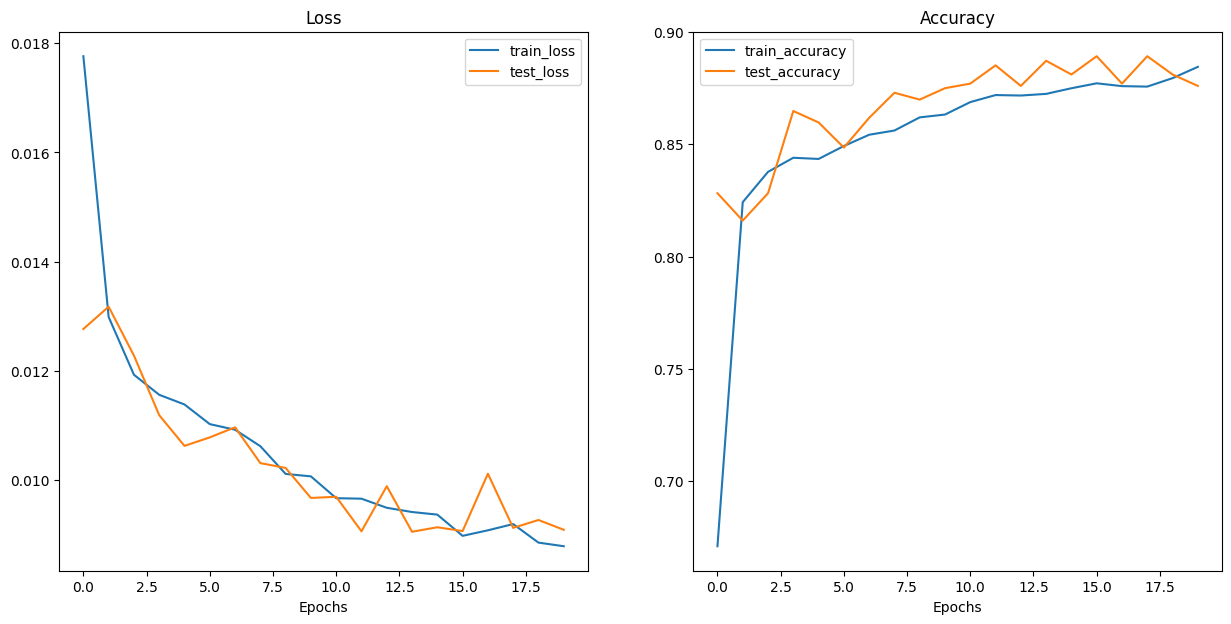

In [35]:
plot_loss_curves(model_0_results)